In [4]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GroupKFold
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import sys
print('Python:',sys.version)

Python: 3.8.18 (default, Sep 11 2023, 13:40:15) 
[GCC 11.2.0]


# Full dataset

In [5]:
df = pd.read_excel("scCO2_all_data(curated).xlsx")

In [6]:
df.head()

,index,Name,SMILES,T (K),P (bar),g (gcm3),y,Lg(y),Ln(y),source,...,TPSA,NR,Bj,HA,HD,RC,SP,NA,NAr,Hat
0,0,Acenaphthene,C1CC2=CC=CC3=CC=CC1=C23,313.15,75.0,0.231532,0.000029,-4.531653,-10.434516,"Lou, X.; Janssen, H.-G.; Cramers, C. A. J. Chr...",...,0.0,0,2.580406,0,0,3,0.166667,1,2,12
1,1,Acenaphthene,C1CC2=CC=CC3=CC=CC1=C23,313.15,80.0,0.277897,0.000056,-4.251037,-9.788375,"Lou, X.; Janssen, H.-G.; Cramers, C. A. J. Chr...",...,0.0,0,2.580406,0,0,3,0.166667,1,2,12
2,2,Acenaphthene,C1CC2=CC=CC3=CC=CC1=C23,313.15,85.0,0.353913,0.000127,-3.896196,-8.971323,"Lou, X.; Janssen, H.-G.; Cramers, C. A. J. Chr...",...,0.0,0,2.580406,0,0,3,0.166667,1,2,12
3,3,Acenaphthene,C1CC2=CC=CC3=CC=CC1=C23,323.15,75.0,0.193935,0.000028,-4.554396,-10.486884,"Lou, X.; Janssen, H.-G.; Cramers, C. A. J. Chr...",...,0.0,0,2.580406,0,0,3,0.166667,1,2,12
4,4,Acenaphthene,C1CC2=CC=CC3=CC=CC1=C23,323.15,80.0,0.219183,0.000041,-4.385103,-10.097072,"Lou, X.; Janssen, H.-G.; Cramers, C. A. J. Chr...",...,0.0,0,2.580406,0,0,3,0.166667,1,2,12


In [7]:
CDK_desc=pd.read_csv("CO2_CDKdesc_Total.csv")
list_descs = pd.read_csv("CDK_DES.csv")["Name"]
des_cdk = CDK_desc[list_descs].fillna(0)

In [8]:
# Random split. Only CDK descriptors

In [9]:
y = df["Lg(y)"]
X=pd.concat([df["T (K)"], df["P (bar)"], des_cdk], axis=1)

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=4321)

In [11]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.962 ± 0.002
RMSE = 0.278 ± 0.008
MAE = 0.183 ± 0.002
AARD = 5.487 ± 0.187


In [12]:
# Random split. CDK with thermodynamic properties

In [13]:
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)

In [14]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.967 ± 0.002
RMSE = 0.261 ± 0.009
MAE = 0.169 ± 0.003
AARD = 4.993 ± 0.155


In [15]:
#Strict split SMILES. Only CDK descriptors

In [16]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [17]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=4321)

In [18]:
X=pd.concat([df["T (K)"], df["P (bar)"], des_cdk], axis=1)

In [19]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=df['SMILES_Canonical']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.694 ± 0.033
RMSE = 0.779 ± 0.05
MAE = 0.582 ± 0.027
AARD = 17.646 ± 2.077


In [20]:
#Strict split SMILES. CDK with thermodynamic properties

In [21]:
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)

In [22]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=df['SMILES_Canonical']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.731 ± 0.027
RMSE = 0.73 ± 0.044
MAE = 0.537 ± 0.018
AARD = 16.397 ± 2.995


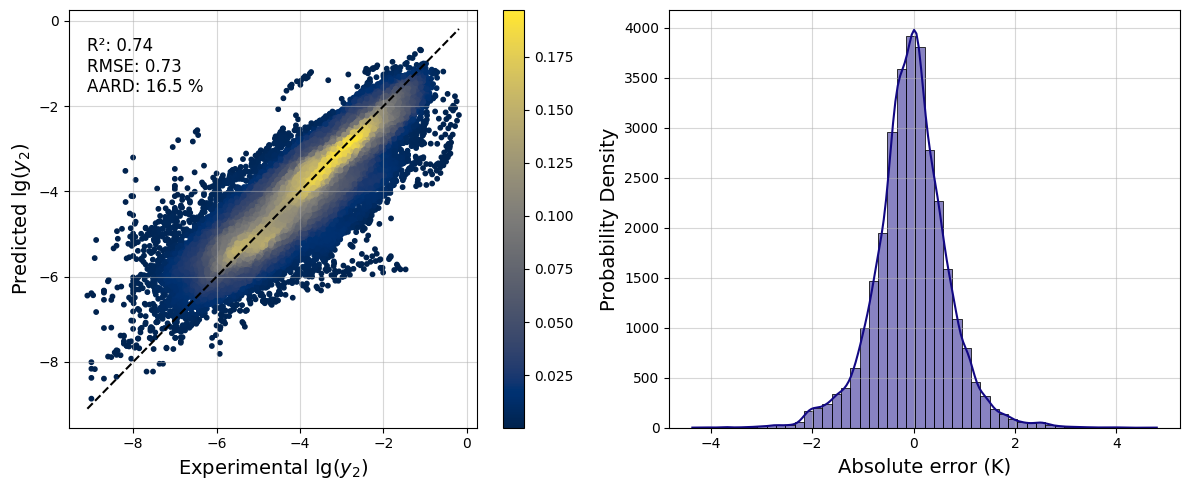

In [23]:
experimental = np.array(Y_true)
predicted = np.array(Y_pred)
errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100 
    return aard

def scatter_density_plot(experimental, predicted):
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=10, cmap='cividis', alpha=1)
    plt.colorbar(scatter)
     
    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')

    plt.xlabel(r'Experimental $\mathrm{lg}(y_2)$', fontsize=14)
    plt.ylabel(r'Predicted $\mathrm{lg}(y_2)$', fontsize=14)
    plt.grid(True, alpha=0.5)

    rmse = np.sqrt(np.mean(errors**2))
    r_squared = np.corrcoef(experimental, predicted)[0, 1]**2
    aard = calculate_aard(experimental, predicted) 
    
    plt.text(min(experimental), max(predicted) - 1, f'R²: {r_squared:.2f}\nRMSE: {rmse:.2f} \nAARD: {aard:.1f} %', fontsize=12)

    plt.subplot(1, 2, 2)
    sns.histplot(errors, kde=True, color='#120884', bins=50)
    plt.xlabel('Absolute error (K)', fontsize=14)
    plt.ylabel('Probability Density', fontsize=14)
    plt.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

scatter_density_plot(experimental, predicted)

In [24]:
#Scaffold split. Only CDK descriptors

In [25]:
X=pd.concat([df["T (K)"], df["P (bar)"], des_cdk], axis=1)

In [26]:
def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol)

df['scaffold'] = df['SMILES_Canonical'].apply(get_scaffold)

In [27]:
df['scaffold_group'] = df['scaffold'].astype('category').cat.codes

In [28]:
class ScaffoldGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            yield train_indices, test_indices

In [29]:
cv = ScaffoldGroupKFold(n_splits=5, shuffle=True, random_state=4321)

In [30]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=df['scaffold_group']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.461 ± 0.058
RMSE = 0.966 ± 0.071
MAE = 0.74 ± 0.054
AARD = 21.258 ± 4.712


In [31]:
#Scaffold split. CDK with thermodynamic properties

In [32]:
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)

In [33]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=df['scaffold_group']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.59 ± 0.027
RMSE = 0.845 ± 0.089
MAE = 0.638 ± 0.087
AARD = 18.353 ± 5.274


# Drug-like dataset

In [34]:
df = pd.read_excel("Drug-like_data.xlsx")

In [35]:
CDK_desc_DL=pd.read_csv("CO2_CDKdesc_DL.csv")
list_descs = pd.read_csv("CDK_DES.csv")["Name"]
des_cdk = CDK_desc_DL[list_descs].fillna(0)

In [36]:
#Strict split SMILES. CDK with thermodynamic properties

In [37]:
y = df["Lg(y)"]
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)

In [38]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=4321)

In [39]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=df['SMILES_Canonical']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.759 ± 0.042
RMSE = 0.686 ± 0.054
MAE = 0.515 ± 0.044
AARD = 16.304 ± 2.295


In [40]:
#Scaffold split. CDK with thermodynamic properties

In [41]:
def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol)

df['scaffold'] = df['SMILES_Canonical'].apply(get_scaffold)

In [42]:
df['scaffold_group'] = df['scaffold'].astype('category').cat.codes

In [43]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=df['scaffold_group']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.637 ± 0.081
RMSE = 0.816 ± 0.095
MAE = 0.634 ± 0.087
AARD = 20.642 ± 5.601
